In [ ]:
# 練習

In [ ]:
# AEモデルの作成

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from LossFunction import SSIMLoss #自作Loss関数

In [2]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 512, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (200, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


In [3]:

losslist=[]

model = mainmodel.Autoencoder_batchnorm()
# criterion = nn.MSELoss()
criterion = SSIMLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
data = torch.from_numpy(data.astype(np.float32)).clone()
for epoch in data:
    for data in epoch:
        recon = model(data)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#     print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    # print('Loss:{:.4f}'.format(float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

make


/Users/yukihorikawa/opt/anaconda3/envs/lab2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yukihorikawa/opt/anaconda3/envs/lab2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yukihorikawa/opt/anaconda3/envs/lab2/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yukihorikawa/opt/anaconda3/envs/lab2/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/yukihorikawa/opt/anaconda3/envs/lab2/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

In [4]:
model_name = "newmodel"
ModelEdit = mainmodel.Modeledit("syuron")
ModelEdit.save_model(model, model_name) 

<class 'torch.Tensor'>


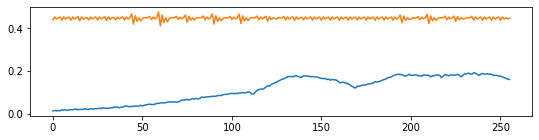

normal:84.7738086283207
anomaly


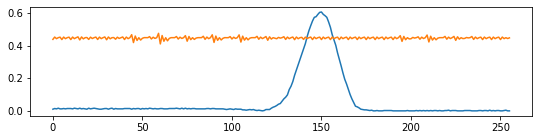

anomarly:101.80898091197014
anomaly
<class 'torch.Tensor'>


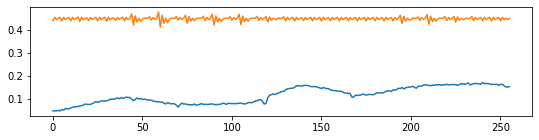

normal:84.42537668347359
anomaly


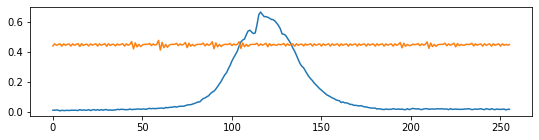

anomarly:90.19336315989494
anomaly
<class 'torch.Tensor'>


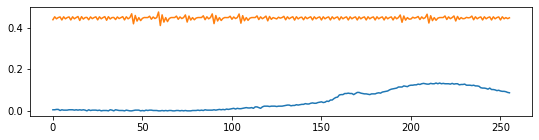

normal:102.17624795436859
anomaly


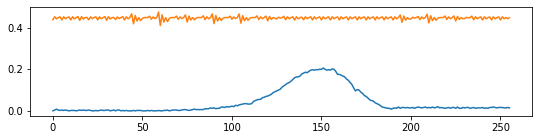

anomarly:103.54619188606739
anomaly
<class 'torch.Tensor'>


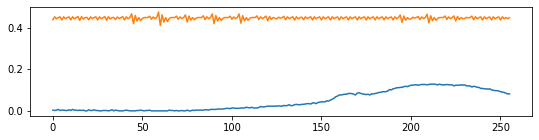

normal:102.38879150152206
anomaly


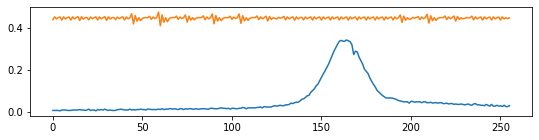

anomarly:99.86111997067928
anomaly
<class 'torch.Tensor'>


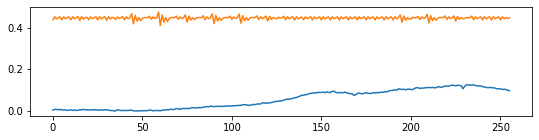

normal:100.35743233561516
anomaly


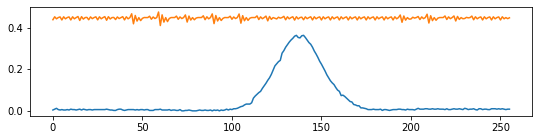

anomarly:101.51551750302315
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [5]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

# oc-svm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

In [ ]:
import dataloader

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)

input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth", map_location=device))

# input_model = model

recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

In [ ]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()

## grid search original

# grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
scores = ['precision', 'recall']
nus = [0.001, 0.01, 0.1, 0.002, 0.02, 0.2, 1]
gammas = [0.001, 0.01, 0.1, 0.002, 0.02, 0.2, 1]
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}
for score in scores:
    clf = GridSearchCV(svm.OneClassSVM(), tuned_parameters, cv=10,
                        scoring='%s_macro' % score, return_train_score=True)

    clf.fit(X_train)

    resultDf = pd.DataFrame(clf.cv_results_)
    print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

In [ ]:
X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list
print("X_anomaly:{}, X_test:{}, X_train{}".format(X_anomaly.shape[0], X_test.shape[0], X_train.shape[0]))
span = 0.001
nus = np.arange(span, 0.01+span, span, dtype = 'float64')
print(nus)
gammas = np.arange(span, 0.01+span, span, dtype = 'float64')
point_test = X_test.shape[0]
point_test_def = 0
poit_error = 0
poit_error_def = X_anomaly.shape[0]
standar_point = 5
parameter = []


nus = [0.001, 0.01, 0.1, 0.002, 0.02, 0.2, 0.003, 0.03, 0.3, 0.004, 0.04, 0.4, 0.005, 0.05, 0.5, 0.006, 0.06, 0.6, 0.007, 0.07, 0.7, 0.008, 0.08, 0.8, 0.009, 0.09, 0.9, 1]
gammas = [0.001, 0.01, 0.1, 0.002, 0.02, 0.2, 0.003, 0.03, 0.3, 0.004, 0.04, 0.4, 0.005, 0.05, 0.5, 0.006, 0.06, 0.6, 0.007, 0.07, 0.7, 0.008, 0.08, 0.8, 0.009, 0.09, 0.9, 1]
num = len(nus)

for i in range(num):
    for j in range(num):
        clf = svm.OneClassSVM(nu=nus[i], kernel="rbf", gamma=gammas[j])
        clf.fit(X_train)
        y_pred_test = clf.predict(X_test)
        y_pred_anomaly = clf.predict(X_anomaly)
        n_error_test = y_pred_test[y_pred_test == -1].size
        n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
        print("n_error_test{}".format(n_error_test))
        print("n_error_anomaly{}".format(n_error_anomaly))
        print("poit_error_def - n_error_anomaly{}".format(poit_error_def - n_error_anomaly))
        if standar_point > n_error_test + (poit_error_def - n_error_anomaly):
            parameter.append([nus[i], gammas[j], n_error_test+poit_error_def - n_error_anomaly])
            # standar_point = point_test + (poit_error_def - poit_error)
        # if poit_error < n_error_anomaly:
        #     poit_error = n_error_anomaly
        #     if point_test > n_error_test:
        #         point_test = n_error_test
        #         print("y_pred_test:{} ".format(point_test ))
        #         print("y_pred_anomaly:{} ".format(poit_error ))
        #         parameter.append([nus[i], gammas[j]])
        #         print("prameter{}".format(parameter))
                # standar_point = point_test + (poit_error_def - poit_error)
print(parameter)

In [ ]:
for i in range(anomaly_data.shape[0]):
    # if i % 10 == 0:
    data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
    test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
    print(type(data0))
    plt.figure(figsize=(9, 2))
    # data = data0.numpy()
    data = data0[np.newaxis, np.newaxis, :]
    recon = input_model(data).detach().numpy()
    plt.plot(data0.numpy())
    plt.plot(recon.flatten())
    plt.show()
    
    anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
    print("normal:"+str(anomalypoint))
    if(anomalypoint>10):
        print("anomaly")
        
    plt.figure(figsize=(9, 2))
    # data = test0.numpy()
    data = test0[np.newaxis, np.newaxis, :]
    recon = input_model(data).detach().numpy()
    plt.plot(test0.numpy(),label="testdata")
    plt.plot(recon.flatten(),label="recondata")
    plt.show()
    
    anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
    print("anomarly:"+str(anomalypoint))
    if(anomalypoint>10):
        print("anomaly")

## 時間計測

### OCSVM

In [ ]:
from sklearn.svm import OneClassSVM

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

import dataloader

In [ ]:
import dataloader

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)

input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth", map_location=device))

# input_model = model

recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

In [ ]:
import dataloader

#---------for AE------------
input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth", map_location=device))

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)

#---------for OCSVM------------

Dataset = dataset.dataset("Obrid_AE", "data")
ocs_data, ocs_test_data , ocs_anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, ocs_data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, ocs_test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, ocs_anomaly_data)

ocs_X_anomaly = anomaly_encoded_list
ocs_X_test = test_encoded_list
ocs_X_train = encoded_list
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(ocs_X_train)

#---------計測用---------
num = 100
len = ocs_X_train.shape[0]
# ocs_X_train = X_train[np.newaxis, :]#２次元のサイズでないとエラー

In [ ]:
import dataloader

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)

input_model = mainmodel.Autoencoder2()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder2().to(device)
input_model.load_state_dict(torch.load("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth", map_location=device))

# input_model = model

recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)
X_train = encoded_list
X_train = X_train[np.newaxis, :]#２次元のサイズでないとエラー

In [ ]:
ocs_X_train.shape
ocs_X_train = X_train[np.newaxis, :]#２次元のサイズでないとエラー

In [ ]:
%%time
num = 100
len = X_train.shape[0]
for i in range(num):
    for i in range(len):
        y_pred_train = clf.predict(X_train[i])

In [ ]:

Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 1000, 256, 1)
data =  torch.from_numpy((data).astype(np.float32)).clone()
print(data.shape)

In [ ]:

%%time
num = 100
for i in range(num):
    for i in range(len):
        y_pred_train = input_model(data[i]).detach().numpy()


# for i in range(anomaly_data.shape[0]):
#     if i % 10 == 0:
#         data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
#         test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
#         print(type(data0))
#         plt.figure(figsize=(9, 2))
#         # data = data0.numpy()
#         data = data0[np.newaxis, np.newaxis, :]
#         recon = model(data).detach().numpy()
#         plt.plot(data0.numpy())
#         plt.plot(recon.flatten())
#         plt.show()
        
#         anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
#         print("normal:"+str(anomalypoint))
#         if(anomalypoint>10):
#             print("anomaly")
            
#         plt.figure(figsize=(9, 2))
#         # data = test0.numpy()
#         data = test0[np.newaxis, np.newaxis, :]
#         recon = model(data).detach().numpy()
#         plt.plot(test0.numpy(),label="testdata")
#         plt.plot(recon.flatten(),label="recondata")
#         plt.show()
        
#         anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
#         print("anomarly:"+str(anomalypoint))
#         if(anomalypoint>10):
#             print("anomaly")